In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ast
import datetime
from collections import Counter

In [2]:
metadata = pd.read_csv('movies_dataset/movies_metadata.csv')

C:\Users\giaco\Anaconda3\envs\ada\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### Temporal dimension

Let's extract from the release_date feature the weekday, month and year for each movie. We will use the datetime function weekday() to extract the corresponding day of the week (as it is far more interesting than the actual number) and directly convert the month number to the corresponding name (01 to 'Jan' for instance).

In [3]:
month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
day_order = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

In [4]:
def get_year(x):
    try:
        year = int(str(x).split('-')[0])
        #Check if year is larger than 1800 since some values do not make sense (a 1 has been found)
        if year < 1800:
            year = np.nan
        return year
    except:
        return np.nan

In [5]:
def get_month(x):
    try:
        return month_order[int(str(x).split('-')[1]) - 1]
    except:
        return np.nan

In [6]:
def get_day(x):
    try:
        year, month, day = (int(i) for i in x.split('-')) 
        answer = datetime.date(year, month, day).weekday()
        return day_order[answer]
    except:
        return np.nan

In [7]:
metadata['year'] = metadata.release_date.map(lambda x: get_year(x))
metadata['month'] = metadata.release_date.map(lambda x: get_month(x))
metadata['weekday'] = metadata.release_date.map(lambda x: get_day(x))

### Genres

Let's extract the various genres a movie is associated with.

In [8]:
metadata['genres'] = metadata['genres'].fillna('[]').apply(ast.literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

In [9]:
genres_count = Counter()
for genre_list in metadata['genres'].values:
    genres_count.update(genre_list)

In [10]:
genres_df = pd.DataFrame(columns = ['Genre','Number of films'])
for (i, genre) in enumerate(genres_count.keys()):
    if genres_count[genre] > 1000:
        genres_df = genres_df.append(pd.DataFrame({'Genre':genre, 'Number of films':genres_count[genre]}, index = [i]))

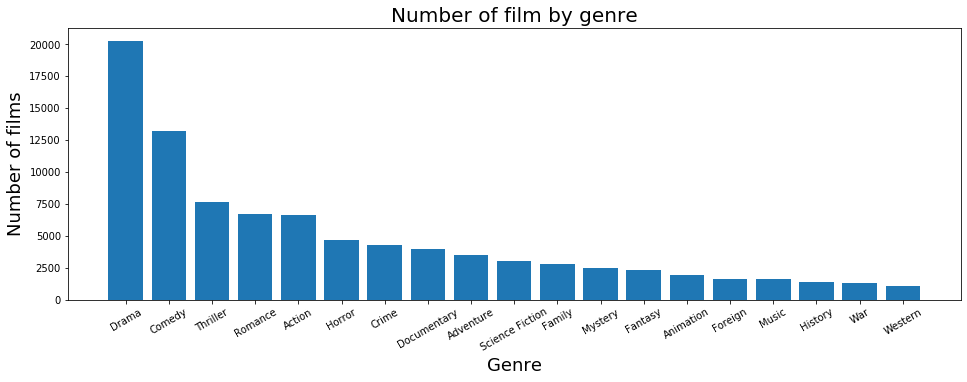

In [11]:
genres_df = genres_df.sort_values('Number of films', ascending = False)
plt.figure(figsize = (16,5))
plt.bar(x = genres_df['Genre'], height = genres_df['Number of films'])
plt.title('Number of film by genre', fontsize = 20)
plt.xlabel('Genre', fontsize = 18)
plt.ylabel('Number of films', fontsize = 18)
plt.xticks(rotation = 30)
plt.show()

In [12]:
metadata.columns

Index(['adult', 'belongs_to_collection', 'budget', 'genres', 'homepage', 'id',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'video',
       'vote_average', 'vote_count', 'year', 'month', 'weekday'],
      dtype='object')

In [13]:
def extractYearMonth(date_str):
    if type(date_str) == str:
        if len(date_str) > 7:
            return date_str[:7]
    else:
        return np.nan

In [14]:
genres_year_df = metadata[['genres', 'month', 'year', 'release_date']]
genres_year_df['date'] = genres_year_df.release_date.map(lambda x: extractYearMonth(x))
genres_year_df

C:\Users\giaco\Anaconda3\envs\ada\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,genres,month,year,release_date,date
0,"[Animation, Comedy, Family]",Oct,1995.0,1995-10-30,1995-10
1,"[Adventure, Fantasy, Family]",Dec,1995.0,1995-12-15,1995-12
2,"[Romance, Comedy]",Dec,1995.0,1995-12-22,1995-12
3,"[Comedy, Drama, Romance]",Dec,1995.0,1995-12-22,1995-12
4,[Comedy],Feb,1995.0,1995-02-10,1995-02
...,...,...,...,...,...
45461,"[Drama, Family]",NaN,NaN,NaN,NaN
45462,[Drama],Nov,2011.0,2011-11-17,2011-11
45463,"[Action, Drama, Thriller]",Aug,2003.0,2003-08-01,2003-08
45464,[],Oct,1917.0,1917-10-21,1917-10


In [17]:
genres_year_df = genres_year_df.explode(column = 'genres')
genres_year_df

,genres,month,year,release_date,date
0,Animation,Oct,1995.0,1995-10-30,1995-10
0,Comedy,Oct,1995.0,1995-10-30,1995-10
0,Family,Oct,1995.0,1995-10-30,1995-10
0,Animation,Oct,1995.0,1995-10-30,1995-10
0,Comedy,Oct,1995.0,1995-10-30,1995-10
...,...,...,...,...,...
45463,Action,Aug,2003.0,2003-08-01,2003-08
45463,Drama,Aug,2003.0,2003-08-01,2003-08
45463,Thriller,Aug,2003.0,2003-08-01,2003-08
45464,NaN,Oct,1917.0,1917-10-21,1917-10


### Data for the bar chart race

https://observablehq.com/@d3/bar-chart-race-explained

The data for the race is a CSV with columns date (in YYYY-MM-DD format), name, value and optionally category (which if present determines color).

In [55]:
data_race = genres_year_df.groupby(['year', 'genres']).count().month
data_race = data_race.reset_index()

In [56]:
data_race['date'] = data_race['year'].map(lambda x: str(int(x)) + '-01-01')
data_race.rename({'genres':'name', 'month':'value'}, axis = 'columns', inplace = True)
data_race = data_race[['date', 'name', 'value']].dropna()

In [57]:
data_race

,date,name,value
0,1874-01-01,Documentary,1
1,1878-01-01,Documentary,1
2,1883-01-01,Documentary,1
3,1887-01-01,Documentary,1
4,1888-01-01,Documentary,2
...,...,...,...
2016,2018-01-01,Thriller,3
2017,2020-01-01,Action,4
2018,2020-01-01,Adventure,4
2019,2020-01-01,Fantasy,4


In [58]:
for date in data_race.date.unique():
    for genre in data_race.name.unique():
        if genre not in data_race[data_race.date == date].name:
            data_race = data_race.append({'date':date, 'name':genre, 'value':0}, ignore_index = True)

In [59]:
data_race.sort_values('date')

,date,name,value
0,1874-01-01,Documentary,1
2039,1874-01-01,Foreign,0
2038,1874-01-01,Mystery,0
2037,1874-01-01,Western,0
2036,1874-01-01,Music,0
...,...,...,...
2018,2020-01-01,Adventure,4
2019,2020-01-01,Fantasy,4
2020,2020-01-01,Science Fiction,4
4707,2020-01-01,Fantasy,0


In [69]:
data_race[data_race.name == 'Mystery'].value.cumsum()

135        2
157        7
181       10
219       17
243       21
        ... 
4638    7984
4658    7984
4678    7984
4698    7984
4718    7984
Name: value, Length: 232, dtype: int64

In [100]:
test = data_race[data_race.name == 'Documentary']
test.value = test.sort_values('date').value.cumsum()
test.sort_values('date')

,date,name,value
0,1874-01-01,Documentary,1
2021,1874-01-01,Documentary,1
2041,1878-01-01,Documentary,1
1,1878-01-01,Documentary,2
2,1883-01-01,Documentary,3
...,...,...,...
1976,2016-01-01,Documentary,5358
4661,2017-01-01,Documentary,5358
1995,2017-01-01,Documentary,5440
4681,2018-01-01,Documentary,5440


In [99]:
test2 = data_race[data_race.name == 'Mystery']
test2.value = test2.sort_values('date').value.cumsum()
test2.sort_values('date')

,date,name,value
2038,1874-01-01,Mystery,0
2058,1878-01-01,Mystery,0
2078,1883-01-01,Mystery,0
2098,1887-01-01,Mystery,0
2118,1888-01-01,Mystery,0
...,...,...,...
1983,2016-01-01,Mystery,7890
4678,2017-01-01,Mystery,7890
2002,2017-01-01,Mystery,7984
4698,2018-01-01,Mystery,7984


In [107]:
test.append(test2).sort_values("date").drop_duplicates(subset = ['date', 'name']).date.value_counts()

1943-01-01    2
1941-01-01    2
1994-01-01    2
1890-01-01    2
1952-01-01    2
             ..
1916-01-01    2
2000-01-01    2
1934-01-01    2
1966-01-01    2
1927-01-01    2
Name: date, Length: 135, dtype: int64

In [108]:
data_cumulative = pd.DataFrame(columns = ['date', 'name', 'value'])
for genre in data_race['name'].unique():
    temp = data_race[data_race.name == genre]
    temp.value = temp.sort_values('date').value.cumsum()
    data_cumulative = data_cumulative.append(temp, ignore_index = True).drop_duplicates(subset = ['date', 'name'])

C:\Users\giaco\Anaconda3\envs\ada\lib\site-packages\pandas\core\generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [109]:
data_cumulative.sort_values('date')

,date,name,value
0,1874-01-01,Documentary,1
2392,1874-01-01,Mystery,0
2261,1874-01-01,Western,0
2117,1874-01-01,Music,0
1997,1874-01-01,Adventure,0
...,...,...,...
1996,2020-01-01,Adventure,11716
2159,2020-01-01,Music,4199
2294,2020-01-01,Western,2381
1214,2020-01-01,Romance,18512


In [110]:
data_cumulative.to_csv('Data/data_cumulative_race.csv', columns = ['date', 'name', 'value'], index = False)

### Data for stacked area chart

https://observablehq.com/@d3/stacked-area-chart

Format: {'date':xxx, 'GenreName':'Genre1', 'value':NumFilmsGenre1} for each time period & each genre

In [116]:
data_race = data_race.sort_values('date').drop_duplicates(subset = ['date', 'name'])
data_race

,date,name,value
0,1874-01-01,Documentary,1
2039,1874-01-01,Foreign,0
2038,1874-01-01,Mystery,0
2037,1874-01-01,Western,0
2036,1874-01-01,Music,0
...,...,...,...
4703,2020-01-01,Action,0
4702,2020-01-01,Comedy,0
4701,2020-01-01,Documentary,0
2019,2020-01-01,Fantasy,4


In [190]:
data_area_stacked = data_race.pivot(index='date', columns='name', values='value')

In [183]:
data_area_stacked.index = pd.to_datetime(data_area_stacked.index)

In [184]:
data_area_stacked_5years = data_area_stacked.resample('5Y').sum().iloc[:-1]

In [189]:
data_area_stacked_10years = data_area_stacked.resample('10Y').sum().iloc[:-1]

In [188]:
data_area_stacked_5years.reset_index().to_csv('Data/data_area_stacked_5years.csv', index = False)
data_area_stacked_10years.reset_index().to_csv('Data/data_area_stacked_10years.csv', index = False)